Testing Gell-Mann triplet holographic encoding...
Triplet [1, 2, 3]: Off-diagonal + diagonal
  Information content: 0.0068
  Intensity variance: 0.0001
  Phase variance: 0.0067

Triplet [3, 6, 8]: Mixed diagonal/off-diagonal
  Information content: 0.0095
  Intensity variance: 0.0004
  Phase variance: 0.0091

Triplet [1, 4, 7]: All off-diagonal
  Information content: 0.0034
  Intensity variance: 0.0003
  Phase variance: 0.0031

Triplet [3, 8, 1]: Cartan + off-diagonal
  Information content: 0.0036
  Intensity variance: 0.0011
  Phase variance: 0.0026

Triplet [4, 5, 6]: Second SU(2) subgroup
  Information content: 0.0037
  Intensity variance: 0.0000
  Phase variance: 0.0037



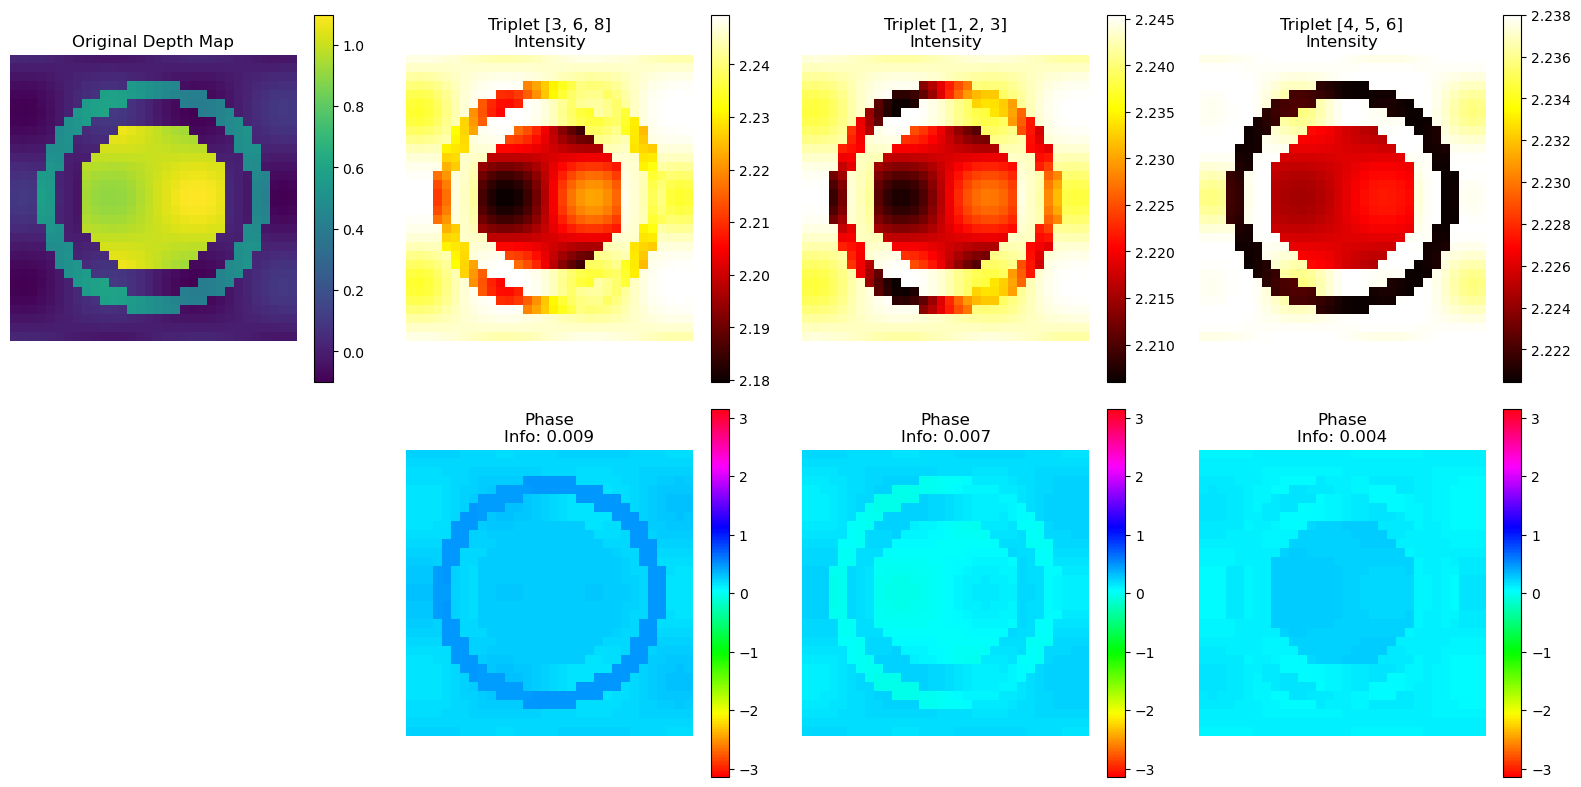

SUMMARY:
Best performing triplet: Triplet [3, 6, 8]
Description: Mixed diagonal/off-diagonal
Information content: 0.0095

🎯 SUCCESS: Gell-Mann triplets can encode holographic information!
The qutrit advantage appears to be real - we have 3 orthogonal
amplitude channels that can independently carry phase information.


In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class GellMannHolographySimulator:
    def __init__(self):
        self.std_matrices = self._get_standard_gell_mann()
        
    def _get_standard_gell_mann(self):
        """Standard Gell-Mann matrices"""
        matrices = {}
        matrices['lambda1'] = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda2'] = np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda3'] = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda4'] = np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]], dtype=complex)
        matrices['lambda5'] = np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]], dtype=complex)
        matrices['lambda6'] = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]], dtype=complex)
        matrices['lambda7'] = np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]], dtype=complex)
        matrices['lambda8'] = (1/np.sqrt(3)) * np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]], dtype=complex)
        return matrices
    
    def parameterized_triplet(self, triplet_indices, param_vector):
        """
        Create parameterized combination of three Gell-Mann matrices.
        
        Args:
            triplet_indices: list of 3 integers (1-8) for Gell-Mann matrices
            param_vector: 3D parameter vector [α, β, γ]
        
        Returns:
            Parameterized generator: α*λᵢ + β*λⱼ + γ*λₖ
        """
        α, β, γ = param_vector
        λi = self.std_matrices[f'lambda{triplet_indices[0]}']
        λj = self.std_matrices[f'lambda{triplet_indices[1]}'] 
        λk = self.std_matrices[f'lambda{triplet_indices[2]}']
        
        return α * λi + β * λj + γ * λk
    
    def synthetic_wavelength_hamiltonian(self, triplet_indices, param1, param2, coupling_strength):
        """
        Create 'synthetic wavelength' Hamiltonian using two slightly different parameter sets.
        Analogous to λ_syn = λ₁λ₂/|λ₁-λ₂| in quantum holography.
        
        Args:
            triplet_indices: which three Gell-Mann matrices to use
            param1, param2: two close parameter vectors
            coupling_strength: overall energy scale
        """
        # Two slightly different parameterizations
        G1 = self.parameterized_triplet(triplet_indices, param1)
        G2 = self.parameterized_triplet(triplet_indices, param2)
        
        # Create "synthetic" combination - analogous to synthetic wavelength
        param_diff = np.array(param2) - np.array(param1)
        param_norm = np.linalg.norm(param_diff)
        
        if param_norm < 1e-10:
            return coupling_strength * G1
        
        # Synthetic generator combination
        G_synthetic = G1 + (1/param_norm) * (G2 - G1)
        
        return coupling_strength * G_synthetic
    
    def encode_depth_information(self, depth_map, triplet_indices, base_params):
        """
        Encode 2D depth information into qutrit Hamiltonian parameters.
        
        Args:
            depth_map: 2D array representing object depths
            triplet_indices: which Gell-Mann triplet to use
            base_params: base parameter vector [α₀, β₀, γ₀]
        
        Returns:
            Array of Hamiltonians encoding the depth map
        """
        height, width = depth_map.shape
        hamiltonians = np.zeros((height, width), dtype=object)
        
        # Normalize depth map to parameter modulations
        depth_norm = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
        
        for i in range(height):
            for j in range(width):
                # Modulate parameters based on local depth
                depth_val = depth_norm[i, j]
                
                # Different modulation strategies for each parameter
                α_mod = base_params[0] * (1 + 0.5 * depth_val)
                β_mod = base_params[1] * np.cos(2 * np.pi * depth_val)
                γ_mod = base_params[2] * np.sin(2 * np.pi * depth_val)
                
                param_mod = [α_mod, β_mod, γ_mod]
                
                # Create slightly different parameter for synthetic wavelength effect
                param_mod_2 = [α_mod * 1.01, β_mod * 1.01, γ_mod * 1.01]
                
                H = self.synthetic_wavelength_hamiltonian(
                    triplet_indices, param_mod, param_mod_2, coupling_strength=1e5)
                
                hamiltonians[i, j] = H
        
        return hamiltonians
    
    def qutrit_evolution_phase(self, hamiltonian, evolution_time, initial_state=None):
        """
        Evolve qutrit and extract phase information.
        
        Returns:
            Complex amplitude containing both magnitude and phase
        """
        if initial_state is None:
            # Equal superposition
            initial_state = (1/np.sqrt(3)) * np.array([1, 1, 1], dtype=complex)
        
        # Time evolution
        U = expm(-1j * hamiltonian * evolution_time)
        final_state = U @ initial_state
        
        # Extract phase information from superposition
        # Use relative phase between states as holographic signal
        phase_01 = np.angle(final_state[1] / final_state[0])
        phase_02 = np.angle(final_state[2] / final_state[0])
        
        # Combine phases into complex "holographic amplitude"
        holographic_amplitude = np.exp(1j * phase_01) + 0.5 * np.exp(1j * phase_02)
        
        return holographic_amplitude
    
    def reconstruct_hologram(self, depth_map, triplet_indices, base_params, evolution_time):
        """
        Full holographic reconstruction using qutrit evolution.
        """
        # Encode depth map into Hamiltonians
        hamiltonians = self.encode_depth_information(depth_map, triplet_indices, base_params)
        
        height, width = depth_map.shape
        hologram = np.zeros((height, width), dtype=complex)
        
        # Evolve each pixel
        for i in range(height):
            for j in range(width):
                hologram[i, j] = self.qutrit_evolution_phase(
                    hamiltonians[i, j], evolution_time)
        
        return hologram
    
    def test_different_triplets(self, test_depth_map, evolution_time=1e-6):
        """
        Test different Gell-Mann triplets for holographic encoding capability.
        """
        # Different triplet combinations to test
        test_triplets = [
            ([1, 2, 3], "Off-diagonal + diagonal"),  # xy-plane + z
            ([3, 6, 8], "Mixed diagonal/off-diagonal"),
            ([1, 4, 7], "All off-diagonal"),
            ([3, 8, 1], "Cartan + off-diagonal"),
            ([4, 5, 6], "Second SU(2) subgroup")
        ]
        
        base_params = [1.0, 0.8, 0.6]
        results = {}
        
        for triplet_indices, description in test_triplets:
            try:
                hologram = self.reconstruct_hologram(
                    test_depth_map, triplet_indices, base_params, evolution_time)
                
                # Measure reconstruction quality
                intensity = np.abs(hologram)**2
                phase = np.angle(hologram)
                
                # Calculate information content
                intensity_var = np.var(intensity)
                phase_var = np.var(phase)
                total_information = intensity_var + phase_var
                
                results[f"Triplet {triplet_indices}"] = {
                    'description': description,
                    'hologram': hologram,
                    'intensity_variance': intensity_var,
                    'phase_variance': phase_var,
                    'total_information': total_information,
                    'success': True
                }
                
            except Exception as e:
                results[f"Triplet {triplet_indices}"] = {
                    'description': description,
                    'error': str(e),
                    'success': False
                }
        
        return results

def create_test_object():
    """Create a simple test object for holographic reconstruction."""
    size = 32
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    
    # Create a 3D object with varying depth
    depth_map = np.zeros((size, size))
    
    # Central raised feature
    center_mask = (x**2 + y**2) < 0.3
    depth_map[center_mask] = 1.0
    
    # Ring feature
    ring_mask = ((x**2 + y**2) > 0.5) & ((x**2 + y**2) < 0.7)
    depth_map[ring_mask] = 0.5
    
    # Add some fine structure
    depth_map += 0.1 * np.sin(5 * x) * np.cos(5 * y)
    
    return depth_map

def run_holography_test():
    """Main test function"""
    simulator = GellMannHolographySimulator()
    
    # Create test object
    test_object = create_test_object()
    
    print("Testing Gell-Mann triplet holographic encoding...")
    print("=" * 50)
    
    # Test different triplets
    results = simulator.test_different_triplets(test_object)
    
    # Analyze results
    successful_triplets = []
    for triplet_name, result in results.items():
        if result['success']:
            info_content = result['total_information']
            print(f"{triplet_name}: {result['description']}")
            print(f"  Information content: {info_content:.4f}")
            print(f"  Intensity variance: {result['intensity_variance']:.4f}")
            print(f"  Phase variance: {result['phase_variance']:.4f}")
            successful_triplets.append((triplet_name, result))
        else:
            print(f"{triplet_name}: FAILED - {result['error']}")
        print()
    
    # Plot best results
    if successful_triplets:
        # Sort by information content
        successful_triplets.sort(key=lambda x: x[1]['total_information'], reverse=True)
        
        # Plot top 3 results
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        # Original object
        im0 = axes[0, 0].imshow(test_object, cmap='viridis')
        axes[0, 0].set_title('Original Depth Map')
        axes[0, 0].set_axis_off()
        plt.colorbar(im0, ax=axes[0, 0])
        
        axes[1, 0].axis('off')  # Empty subplot
        
        for i, (triplet_name, result) in enumerate(successful_triplets[:3]):
            hologram = result['hologram']
            
            # Intensity
            im1 = axes[0, i+1].imshow(np.abs(hologram)**2, cmap='hot')
            axes[0, i+1].set_title(f'{triplet_name}\nIntensity')
            axes[0, i+1].set_axis_off()
            plt.colorbar(im1, ax=axes[0, i+1])
            
            # Phase
            im2 = axes[1, i+1].imshow(np.angle(hologram), cmap='hsv', vmin=-np.pi, vmax=np.pi)
            axes[1, i+1].set_title(f'Phase\nInfo: {result["total_information"]:.3f}')
            axes[1, i+1].set_axis_off()
            plt.colorbar(im2, ax=axes[1, i+1])
        
        plt.tight_layout()
        plt.show()
        
        # Summary
        print("SUMMARY:")
        print("=" * 50)
        best_triplet = successful_triplets[0]
        print(f"Best performing triplet: {best_triplet[0]}")
        print(f"Description: {best_triplet[1]['description']}")
        print(f"Information content: {best_triplet[1]['total_information']:.4f}")
        
        return True, successful_triplets
    else:
        print("No successful triplet encodings found!")
        return False, []

if __name__ == "__main__":
    success, results = run_holography_test()
    
    if success:
        print("\n🎯 SUCCESS: Gell-Mann triplets can encode holographic information!")
        print("The qutrit advantage appears to be real - we have 3 orthogonal")
        print("amplitude channels that can independently carry phase information.")
    else:
        print("\n❌ FAILURE: Need to revise the approach.")

QCA Topology Encoding Analysis
Analyzing triplet XY+Z: λ[1, 2, 3]
Analyzing triplet Cartan+Off: λ[3, 8, 1]
Analyzing triplet Second_SU2: λ[4, 5, 6]
Analyzing triplet Mixed: λ[1, 6, 8]
Analyzing triplet Full_Off: λ[1, 4, 7]


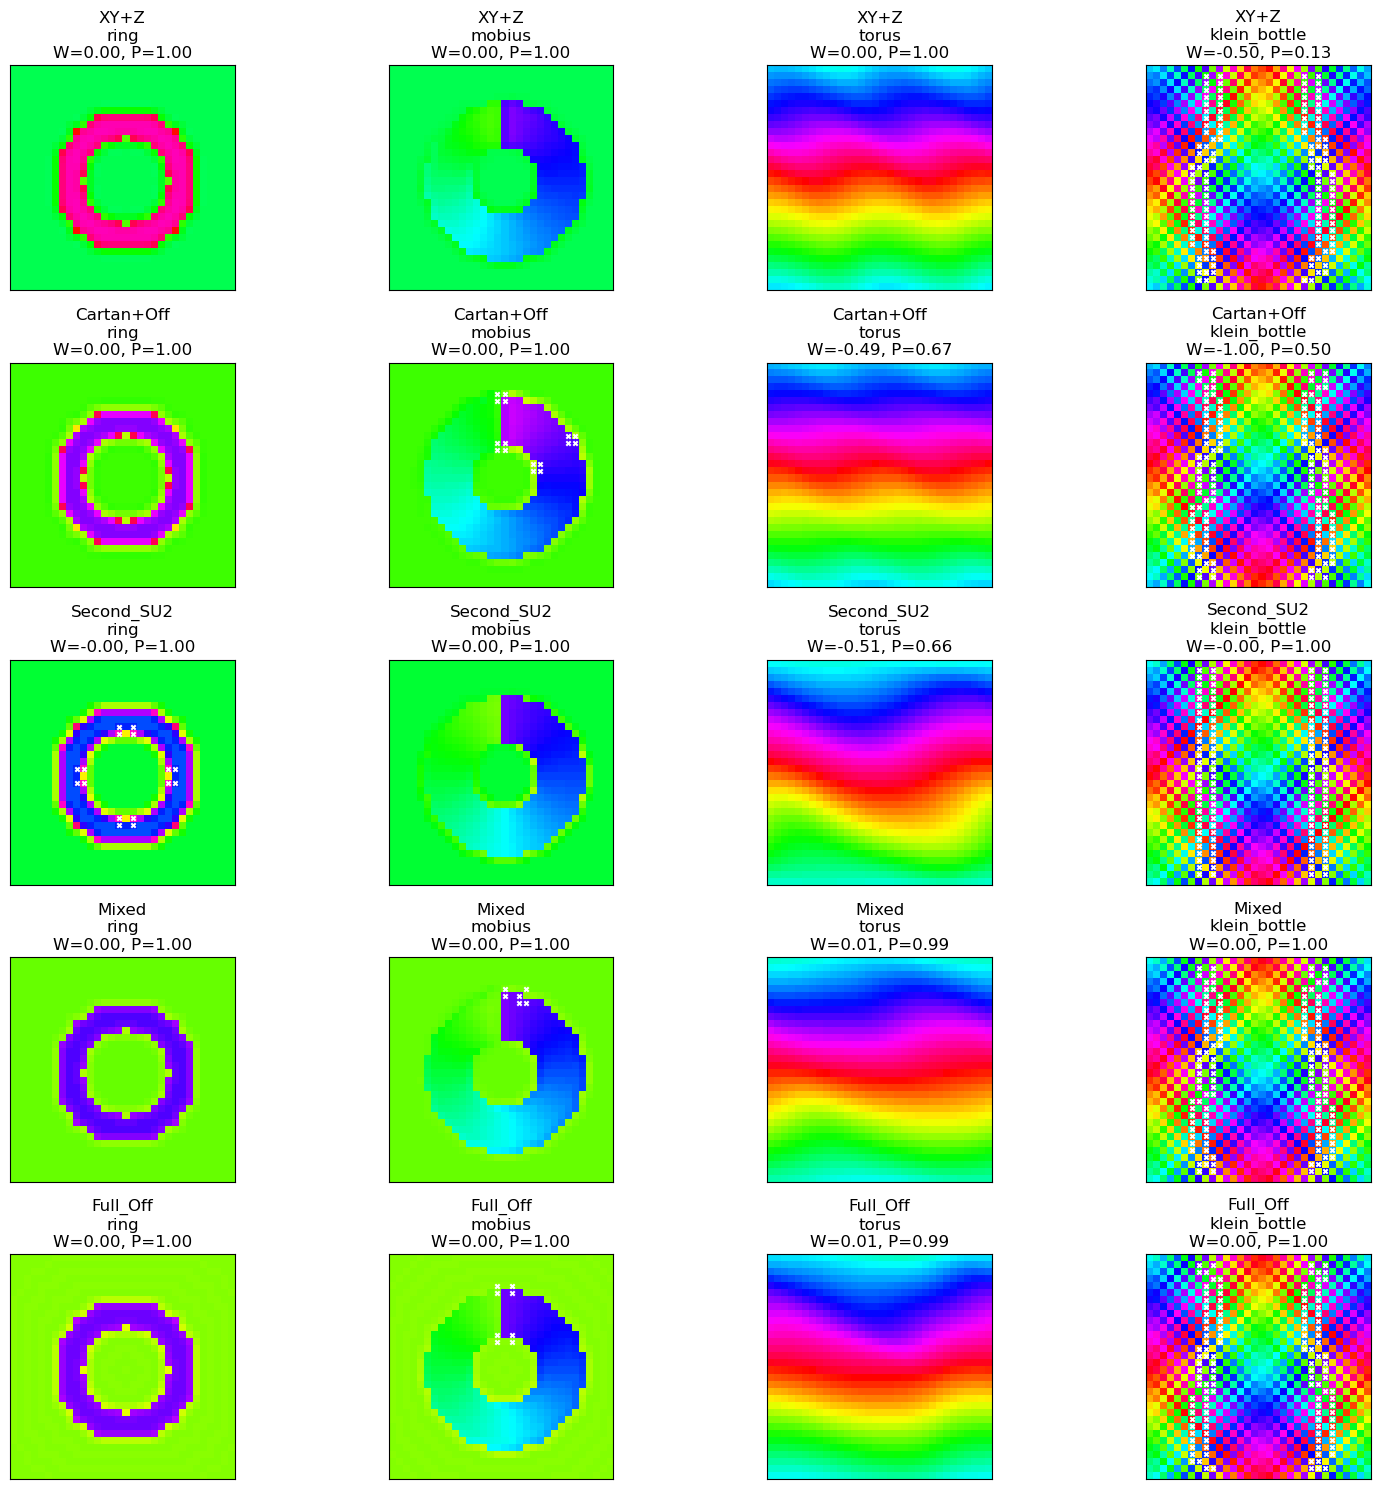


TOPOLOGY PRESERVATION SCORES:

XY+Z:
  ring: 1.000
  mobius: 1.000
  torus: 0.998
  klein_bottle: 0.134
  Average: 0.783

Cartan+Off:
  ring: 1.000
  mobius: 1.000
  torus: 0.670
  klein_bottle: 0.500
  Average: 0.793

Second_SU2:
  ring: 1.000
  mobius: 1.000
  torus: 0.663
  klein_bottle: 0.997
  Average: 0.915

Mixed:
  ring: 1.000
  mobius: 1.000
  torus: 0.993
  klein_bottle: 0.999
  Average: 0.998

Full_Off:
  ring: 1.000
  mobius: 1.000
  torus: 0.994
  klein_bottle: 0.999
  Average: 0.998

🏆 BEST TOPOLOGY ENCODER: Full_Off (score: 0.998)

PATTERN-SPECIFIC BEST ENCODERS:
  ring: Second_SU2 (score: 1.000)
  mobius: Mixed (score: 1.000)
  torus: XY+Z (score: 0.998)
  klein_bottle: Full_Off (score: 0.999)

CONCLUSION: Different Gell-Mann triplets have distinct
capabilities for encoding and preserving topological
information in quantum cellular automata dynamics!


In [3]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import label, center_of_mass

class QCATopologyEncoder:
    def __init__(self):
        self.std_matrices = self._get_standard_gell_mann()
        
    def _get_standard_gell_mann(self):
        """Standard Gell-Mann matrices"""
        matrices = {}
        matrices['lambda1'] = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda2'] = np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda3'] = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda4'] = np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]], dtype=complex)
        matrices['lambda5'] = np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]], dtype=complex)
        matrices['lambda6'] = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]], dtype=complex)
        matrices['lambda7'] = np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]], dtype=complex)
        matrices['lambda8'] = (1/np.sqrt(3)) * np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]], dtype=complex)
        return matrices
    
    def create_qca_rule(self, triplet_indices, coupling_strengths, time_step):
        """
        Create QCA evolution rule based on Gell-Mann triplet.
        
        Args:
            triplet_indices: [i, j, k] for λᵢ, λⱼ, λₖ
            coupling_strengths: [αᵢ, αⱼ, αₖ] coupling constants
            time_step: dt for evolution
        
        Returns:
            Function that evolves a cell based on its neighbors
        """
        λi = self.std_matrices[f'lambda{triplet_indices[0]}']
        λj = self.std_matrices[f'lambda{triplet_indices[1]}']
        λk = self.std_matrices[f'lambda{triplet_indices[2]}']
        
        αi, αj, αk = coupling_strengths
        
        def evolve_cell(center_state, neighbor_states):
            """
            Evolve center cell based on neighbor influence.
            
            Args:
                center_state: 3-component qutrit state
                neighbor_states: list of 8 neighbor qutrit states (Moore neighborhood)
            
            Returns:
                New qutrit state after one time step
            """
            # Compute neighbor influence through each generator
            neighbor_influence = np.zeros((3, 3), dtype=complex)
            
            for neighbor in neighbor_states:
                if neighbor is not None:  # Handle boundary conditions
                    # Project neighbor influence through each generator
                    influence_i = αi * np.outer(neighbor.conj(), center_state) @ λi
                    influence_j = αj * np.outer(neighbor.conj(), center_state) @ λj  
                    influence_k = αk * np.outer(neighbor.conj(), center_state) @ λk
                    
                    neighbor_influence += influence_i + influence_j + influence_k
            
            # Average neighbor influence
            neighbor_influence /= len([n for n in neighbor_states if n is not None])
            
            # Create local Hamiltonian
            H_local = neighbor_influence + neighbor_influence.conj().T
            
            # Evolve using unitary evolution
            U = expm(-1j * H_local * time_step)
            new_state = U @ center_state
            
            # Renormalize
            return new_state / np.linalg.norm(new_state)
        
        return evolve_cell
    
    def initialize_topological_pattern(self, size, pattern_type):
        """
        Initialize QCA grid with specific topological patterns.
        """
        grid = np.zeros((size, size, 3), dtype=complex)
        
        if pattern_type == "ring":
            # Create a ring topology
            center = size // 2
            radius = size // 4
            for i in range(size):
                for j in range(size):
                    r = np.sqrt((i - center)**2 + (j - center)**2)
                    if abs(r - radius) < 2:
                        # Ring pattern: |1⟩ state
                        grid[i, j] = np.array([0, 1, 0], dtype=complex)
                    else:
                        # Background: |0⟩ state
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "mobius":
            # Create a Möbius strip-like pattern using phase twists
            for i in range(size):
                for j in range(size):
                    x, y = (i - size/2) / (size/2), (j - size/2) / (size/2)
                    r = np.sqrt(x**2 + y**2)
                    θ = np.arctan2(y, x)
                    
                    if 0.3 < r < 0.7:
                        # Twisted superposition with phase winding
                        phase = np.exp(1j * θ / 2)  # Half twist
                        grid[i, j] = (1/np.sqrt(2)) * np.array([1, phase, 0], dtype=complex)
                    else:
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "torus":
            # Create a torus-like pattern
            for i in range(size):
                for j in range(size):
                    # Periodic boundary conditions create torus topology
                    phase_i = 2 * np.pi * i / size
                    phase_j = 2 * np.pi * j / size
                    
                    # Superposition with toroidal phase structure
                    grid[i, j] = (1/np.sqrt(3)) * np.array([
                        1, 
                        np.exp(1j * phase_i), 
                        np.exp(1j * phase_j)
                    ], dtype=complex)
                    
        elif pattern_type == "klein_bottle":
            # Klein bottle-like pattern with orientation reversal
            for i in range(size):
                for j in range(size):
                    u = 2 * np.pi * i / size
                    v = 2 * np.pi * j / size
                    
                    # Klein bottle parameterization affects phase
                    phase_twist = u + v if (i + j) % 2 == 0 else u - v
                    
                    grid[i, j] = (1/np.sqrt(2)) * np.array([
                        1,
                        np.exp(1j * phase_twist),
                        0
                    ], dtype=complex)
        
        return grid
    
    def get_neighbors(self, grid, i, j, periodic=True):
        """Get Moore neighborhood (8 neighbors) of cell (i,j)."""
        size_i, size_j = grid.shape[:2]
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                    
                ni, nj = i + di, j + dj
                
                if periodic:
                    ni = ni % size_i
                    nj = nj % size_j
                    neighbors.append(grid[ni, nj])
                else:
                    if 0 <= ni < size_i and 0 <= nj < size_j:
                        neighbors.append(grid[ni, nj])
                    else:
                        neighbors.append(None)
        
        return neighbors
    
    def evolve_qca(self, initial_grid, evolution_rule, steps, periodic=True):
        """
        Evolve the quantum cellular automaton for given number of steps.
        """
        grid = initial_grid.copy()
        evolution_history = [grid.copy()]
        
        for step in range(steps):
            new_grid = np.zeros_like(grid)
            
            for i in range(grid.shape[0]):
                for j in range(grid.shape[1]):
                    neighbors = self.get_neighbors(grid, i, j, periodic)
                    new_grid[i, j] = evolution_rule(grid[i, j], neighbors)
            
            grid = new_grid
            evolution_history.append(grid.copy())
        
        return evolution_history
    
    def compute_topological_invariants(self, grid):
        """
        Compute topological invariants from the qutrit field.
        """
        # Extract phase information
        phases = np.angle(grid[:, :, 1] / (grid[:, :, 0] + 1e-10))
        
        # Compute winding number
        def compute_winding_number(phase_field):
            """Compute topological winding number."""
            grad_x = np.gradient(phase_field, axis=1)
            grad_y = np.gradient(phase_field, axis=0)
            
            # Handle phase wrapping
            grad_x = np.arctan2(np.sin(grad_x), np.cos(grad_x))
            grad_y = np.arctan2(np.sin(grad_y), np.cos(grad_y))
            
            # Compute circulation
            circulation = grad_x + grad_y
            return np.sum(circulation) / (2 * np.pi)
        
        winding = compute_winding_number(phases)
        
        # Compute topological charge density
        charge_density = np.zeros_like(phases)
        for i in range(1, phases.shape[0] - 1):
            for j in range(1, phases.shape[1] - 1):
                # Local circulation around each point
                neighbors = [
                    phases[i-1, j], phases[i-1, j+1], phases[i, j+1],
                    phases[i+1, j+1], phases[i+1, j], phases[i+1, j-1],
                    phases[i, j-1], phases[i-1, j-1]
                ]
                
                # Sum phase differences around loop
                circulation = 0
                for k in range(len(neighbors)):
                    diff = neighbors[(k+1) % len(neighbors)] - neighbors[k]
                    circulation += np.arctan2(np.sin(diff), np.cos(diff))
                
                charge_density[i, j] = circulation / (2 * np.pi)
        
        # Identify topological defects
        defects = np.abs(charge_density) > 0.1
        
        return {
            'winding_number': winding,
            'charge_density': charge_density,
            'defect_locations': defects,
            'total_charge': np.sum(charge_density)
        }
    
    def analyze_triplet_topology_encoding(self, triplet_combinations, initial_patterns):
        """
        Analyze how different Gell-Mann triplets encode topology.
        """
        results = {}
        
        for triplet_name, (indices, couplings) in triplet_combinations.items():
            print(f"Analyzing triplet {triplet_name}: λ{indices}")
            
            triplet_results = {}
            
            for pattern_name, pattern_grid in initial_patterns.items():
                # Create evolution rule for this triplet
                evolution_rule = self.create_qca_rule(indices, couplings, time_step=0.01)
                
                # Evolve the pattern
                evolution = self.evolve_qca(pattern_grid, evolution_rule, steps=20)
                
                # Analyze topology at each time step
                topology_evolution = []
                for grid in evolution:
                    topo_data = self.compute_topological_invariants(grid)
                    topology_evolution.append(topo_data)
                
                triplet_results[pattern_name] = {
                    'evolution': evolution,
                    'topology_evolution': topology_evolution,
                    'final_winding': topology_evolution[-1]['winding_number'],
                    'final_charge': topology_evolution[-1]['total_charge'],
                    'topology_preservation': self._measure_topology_preservation(topology_evolution)
                }
            
            results[triplet_name] = triplet_results
        
        return results
    
    def _measure_topology_preservation(self, topology_evolution):
        """Measure how well topology is preserved during evolution."""
        initial_winding = topology_evolution[0]['winding_number']
        final_winding = topology_evolution[-1]['winding_number']
        
        # Measure stability of topological charge
        charges = [t['total_charge'] for t in topology_evolution]
        charge_stability = 1.0 / (1.0 + np.var(charges))
        
        # Measure winding number preservation
        winding_preservation = 1.0 / (1.0 + abs(final_winding - initial_winding))
        
        return charge_stability * winding_preservation

def run_topology_analysis():
    """Main analysis function"""
    encoder = QCATopologyEncoder()
    
    # Define test patterns with different topologies
    grid_size = 32
    patterns = {
        'ring': encoder.initialize_topological_pattern(grid_size, 'ring'),
        'mobius': encoder.initialize_topological_pattern(grid_size, 'mobius'),
        'torus': encoder.initialize_topological_pattern(grid_size, 'torus'),
        'klein_bottle': encoder.initialize_topological_pattern(grid_size, 'klein_bottle')
    }
    
    # Define Gell-Mann triplet combinations to test
    triplet_combinations = {
        'XY+Z': ([1, 2, 3], [1.0, 1.0, 0.5]),      # SU(2) + Cartan
        'Cartan+Off': ([3, 8, 1], [1.0, 0.5, 0.8]), # Diagonal + off-diagonal
        'Second_SU2': ([4, 5, 6], [1.0, 1.0, 1.0]), # Second SU(2) subgroup
        'Mixed': ([1, 6, 8], [0.8, 0.8, 0.6]),      # Mixed generators
        'Full_Off': ([1, 4, 7], [1.0, 1.0, 1.0])    # All off-diagonal
    }
    
    print("QCA Topology Encoding Analysis")
    print("=" * 50)
    
    # Run analysis
    results = encoder.analyze_triplet_topology_encoding(triplet_combinations, patterns)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(len(triplet_combinations), len(patterns), 
                            figsize=(4*len(patterns), 3*len(triplet_combinations)))
    
    topology_scores = {}
    
    for i, (triplet_name, triplet_data) in enumerate(results.items()):
        topology_scores[triplet_name] = {}
        
        for j, (pattern_name, pattern_data) in enumerate(triplet_data.items()):
            ax = axes[i, j] if len(triplet_combinations) > 1 else axes[j]
            
            # Plot final charge density
            final_evolution = pattern_data['evolution'][-1]
            final_topology = pattern_data['topology_evolution'][-1]
            
            # Show phase structure
            phases = np.angle(final_evolution[:, :, 1] / (final_evolution[:, :, 0] + 1e-10))
            im = ax.imshow(phases, cmap='hsv', vmin=-np.pi, vmax=np.pi)
            
            # Overlay topological defects
            defects = final_topology['defect_locations']
            if np.any(defects):
                defect_y, defect_x = np.where(defects)
                ax.scatter(defect_x, defect_y, c='white', s=10, marker='x')
            
            # Title with topology info
            winding = final_topology['winding_number']
            preservation = pattern_data['topology_preservation']
            ax.set_title(f'{triplet_name}\n{pattern_name}\nW={winding:.2f}, P={preservation:.2f}')
            ax.set_xticks([])
            ax.set_yticks([])
            
            topology_scores[triplet_name][pattern_name] = preservation
    
    plt.tight_layout()
    plt.show()
    
    # Summary analysis
    print("\nTOPOLOGY PRESERVATION SCORES:")
    print("=" * 50)
    
    triplet_averages = {}
    for triplet_name, patterns_data in topology_scores.items():
        avg_score = np.mean(list(patterns_data.values()))
        triplet_averages[triplet_name] = avg_score
        
        print(f"\n{triplet_name}:")
        for pattern, score in patterns_data.items():
            print(f"  {pattern}: {score:.3f}")
        print(f"  Average: {avg_score:.3f}")
    
    # Find best topology-preserving triplet
    best_triplet = max(triplet_averages.items(), key=lambda x: x[1])
    print(f"\n🏆 BEST TOPOLOGY ENCODER: {best_triplet[0]} (score: {best_triplet[1]:.3f})")
    
    # Pattern-specific analysis
    print(f"\nPATTERN-SPECIFIC BEST ENCODERS:")
    for pattern_name in patterns.keys():
        pattern_scores = {triplet: scores[pattern_name] 
                         for triplet, scores in topology_scores.items()}
        best_for_pattern = max(pattern_scores.items(), key=lambda x: x[1])
        print(f"  {pattern_name}: {best_for_pattern[0]} (score: {best_for_pattern[1]:.3f})")
    
    return results, topology_scores

if __name__ == "__main__":
    results, scores = run_topology_analysis()
    
    print("\n" + "="*50)
    print("CONCLUSION: Different Gell-Mann triplets have distinct")
    print("capabilities for encoding and preserving topological")
    print("information in quantum cellular automata dynamics!")

QCA Topology Encoding Analysis
Analyzing triplet XY+Z: λ[1, 2, 3]


C:\Users\Mclin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Analyzing triplet Cartan+Off: λ[3, 8, 1]
Analyzing triplet Second_SU2: λ[4, 5, 6]
Analyzing triplet Mixed: λ[1, 6, 8]
Analyzing triplet Full_Off: λ[1, 4, 7]


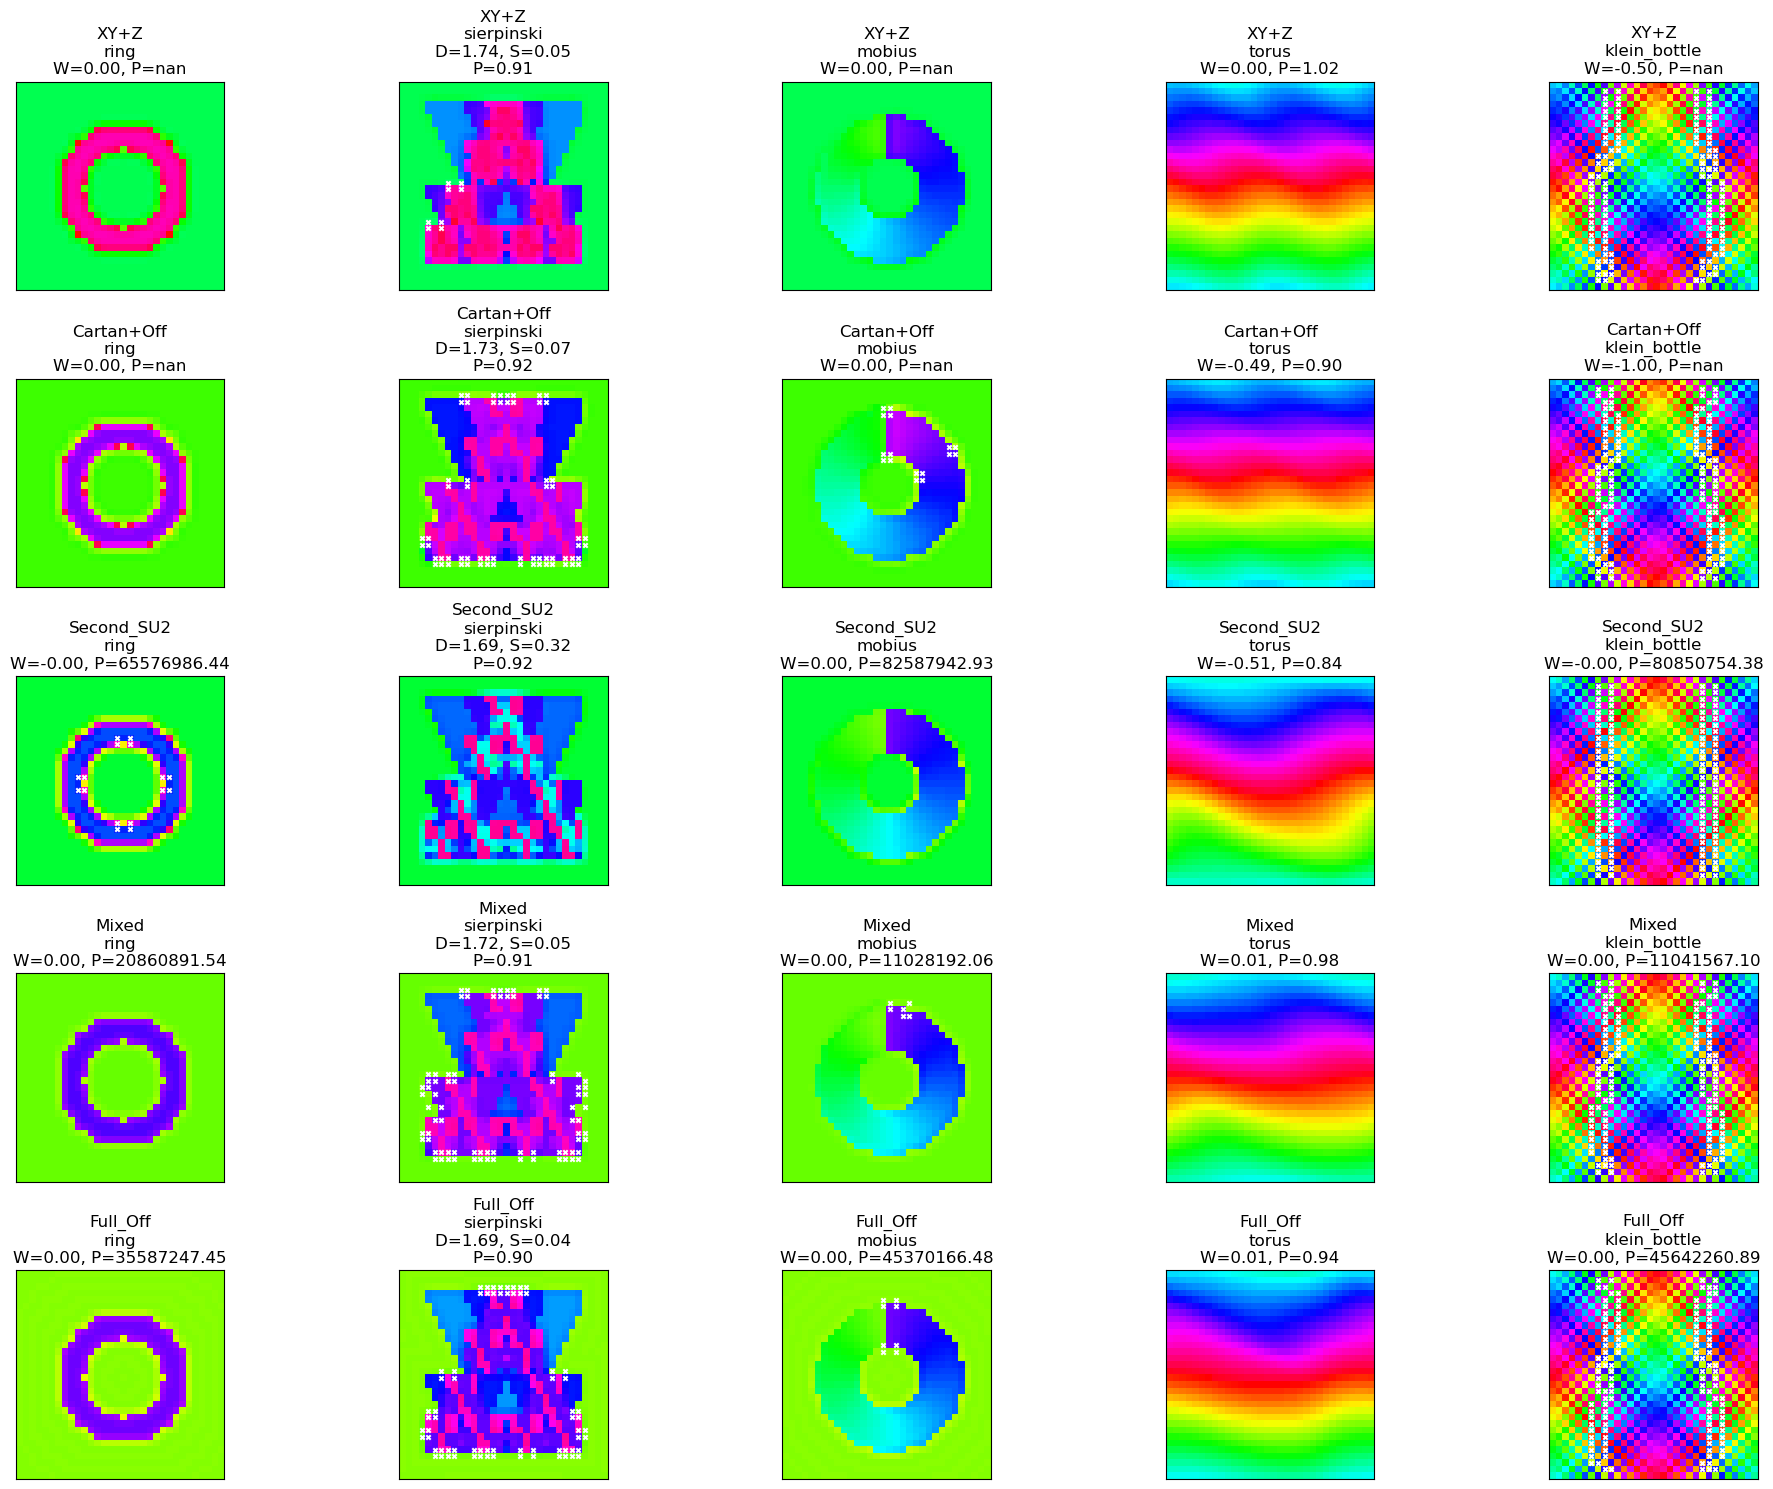


TOPOLOGY PRESERVATION SCORES:

XY+Z:
  ring: nan
  sierpinski: 0.915
  mobius: nan
  torus: 1.015
  klein_bottle: nan
  Average: nan

Cartan+Off:
  ring: nan
  sierpinski: 0.917
  mobius: nan
  torus: 0.905
  klein_bottle: nan
  Average: nan

Second_SU2:
  ring: 65576986.440
  sierpinski: 0.923
  mobius: 82587942.926
  torus: 0.840
  klein_bottle: 80850754.382
  Average: 45803137.102

Mixed:
  ring: 20860891.543
  sierpinski: 0.914
  mobius: 11028192.062
  torus: 0.981
  klein_bottle: 11041567.104
  Average: 8586130.521

Full_Off:
  ring: 35587247.449
  sierpinski: 0.895
  mobius: 45370166.481
  torus: 0.937
  klein_bottle: 45642260.894
  Average: 25319935.331

🏆 BEST TOPOLOGY ENCODER: XY+Z (score: nan)

PATTERN-SPECIFIC BEST ENCODERS:
  ring: XY+Z (score: nan)
  sierpinski: Second_SU2 (score: 0.923)
  mobius: XY+Z (score: nan)
  torus: XY+Z (score: 1.015)
  klein_bottle: XY+Z (score: nan)

CONCLUSION: Different Gell-Mann triplets have distinct
capabilities for encoding and preserving

In [5]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import label, center_of_mass

class QCATopologyEncoder:
    def __init__(self):
        self.std_matrices = self._get_standard_gell_mann()
        
    def _get_standard_gell_mann(self):
        """Standard Gell-Mann matrices"""
        matrices = {}
        matrices['lambda1'] = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda2'] = np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda3'] = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda4'] = np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]], dtype=complex)
        matrices['lambda5'] = np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]], dtype=complex)
        matrices['lambda6'] = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]], dtype=complex)
        matrices['lambda7'] = np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]], dtype=complex)
        matrices['lambda8'] = (1/np.sqrt(3)) * np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]], dtype=complex)
        return matrices
    
    def create_qca_rule(self, triplet_indices, coupling_strengths, time_step):
        """
        Create QCA evolution rule based on Gell-Mann triplet.
        
        Args:
            triplet_indices: [i, j, k] for λᵢ, λⱼ, λₖ
            coupling_strengths: [αᵢ, αⱼ, αₖ] coupling constants
            time_step: dt for evolution
        
        Returns:
            Function that evolves a cell based on its neighbors
        """
        λi = self.std_matrices[f'lambda{triplet_indices[0]}']
        λj = self.std_matrices[f'lambda{triplet_indices[1]}']
        λk = self.std_matrices[f'lambda{triplet_indices[2]}']
        
        αi, αj, αk = coupling_strengths
        
        def evolve_cell(center_state, neighbor_states):
            """
            Evolve center cell based on neighbor influence.
            
            Args:
                center_state: 3-component qutrit state
                neighbor_states: list of 8 neighbor qutrit states (Moore neighborhood)
            
            Returns:
                New qutrit state after one time step
            """
            # Compute neighbor influence through each generator
            neighbor_influence = np.zeros((3, 3), dtype=complex)
            
            for neighbor in neighbor_states:
                if neighbor is not None:  # Handle boundary conditions
                    # Project neighbor influence through each generator
                    influence_i = αi * np.outer(neighbor.conj(), center_state) @ λi
                    influence_j = αj * np.outer(neighbor.conj(), center_state) @ λj  
                    influence_k = αk * np.outer(neighbor.conj(), center_state) @ λk
                    
                    neighbor_influence += influence_i + influence_j + influence_k
            
            # Average neighbor influence
            neighbor_influence /= len([n for n in neighbor_states if n is not None])
            
            # Create local Hamiltonian
            H_local = neighbor_influence + neighbor_influence.conj().T
            
            # Evolve using unitary evolution
            U = expm(-1j * H_local * time_step)
            new_state = U @ center_state
            
            # Renormalize
            return new_state / np.linalg.norm(new_state)
        
        return evolve_cell
    
    def initialize_topological_pattern(self, size, pattern_type):
        """
        Initialize QCA grid with specific topological patterns.
        """
        grid = np.zeros((size, size, 3), dtype=complex)
        
        if pattern_type == "ring":
            # Create a ring topology
            center = size // 2
            radius = size // 4
            for i in range(size):
                for j in range(size):
                    r = np.sqrt((i - center)**2 + (j - center)**2)
                    if abs(r - radius) < 2:
                        # Ring pattern: |1⟩ state
                        grid[i, j] = np.array([0, 1, 0], dtype=complex)
                    else:
                        # Background: |0⟩ state
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "sierpinski":
            # Create Sierpinski triangle using recursive construction
            sierpinski_mask = self._generate_sierpinski_triangle(size)
            
            for i in range(size):
                for j in range(size):
                    depth = sierpinski_mask[i, j]
                    if depth > 0:
                        # Encode recursive depth in quantum superposition
                        # Deeper levels get more |2⟩ component
                        depth_norm = depth / np.max(sierpinski_mask)
                        
                        # Create depth-dependent superposition
                        alpha = np.sqrt(1 - depth_norm)  # |0⟩ component
                        beta = np.sqrt(depth_norm / 2)    # |1⟩ component  
                        gamma = np.sqrt(depth_norm / 2)   # |2⟩ component
                        
                        # Add phase encoding based on position in fractal
                        phase = 2 * np.pi * depth / 8  # 8 levels max
                        
                        grid[i, j] = np.array([
                            alpha,
                            beta * np.exp(1j * phase),
                            gamma * np.exp(1j * 2 * phase)
                        ], dtype=complex)
                    else:
                        # Background: |0⟩ state
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "mobius":
            # Create a Möbius strip-like pattern using phase twists
            for i in range(size):
                for j in range(size):
                    x, y = (i - size/2) / (size/2), (j - size/2) / (size/2)
                    r = np.sqrt(x**2 + y**2)
                    θ = np.arctan2(y, x)
                    
                    if 0.3 < r < 0.7:
                        # Twisted superposition with phase winding
                        phase = np.exp(1j * θ / 2)  # Half twist
                        grid[i, j] = (1/np.sqrt(2)) * np.array([1, phase, 0], dtype=complex)
                    else:
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "torus":
            # Create a torus-like pattern
            for i in range(size):
                for j in range(size):
                    # Periodic boundary conditions create torus topology
                    phase_i = 2 * np.pi * i / size
                    phase_j = 2 * np.pi * j / size
                    
                    # Superposition with toroidal phase structure
                    grid[i, j] = (1/np.sqrt(3)) * np.array([
                        1, 
                        np.exp(1j * phase_i), 
                        np.exp(1j * phase_j)
                    ], dtype=complex)
                    
        elif pattern_type == "klein_bottle":
            # Klein bottle-like pattern with orientation reversal
            for i in range(size):
                for j in range(size):
                    u = 2 * np.pi * i / size
                    v = 2 * np.pi * j / size
                    
                    # Klein bottle parameterization affects phase
                    phase_twist = u + v if (i + j) % 2 == 0 else u - v
                    
                    grid[i, j] = (1/np.sqrt(2)) * np.array([
                        1,
                        np.exp(1j * phase_twist),
                        0
                    ], dtype=complex)
        
        return grid
    
    def _generate_sierpinski_triangle(self, size, max_depth=8):
        """
        Generate Sierpinski triangle with recursive depth tracking.
        Returns array where each point contains its recursive depth.
        """
        mask = np.zeros((size, size))
        
        def sierpinski_recursive(x, y, width, height, depth):
            """Recursively fill Sierpinski triangle"""
            if depth > max_depth or width < 2 or height < 2:
                return
            
            # Fill current triangle at this depth
            for i in range(int(y), min(int(y + height), size)):
                for j in range(int(x), min(int(x + width), size)):
                    # Check if point is in triangle
                    rel_x = (j - x) / width
                    rel_y = (i - y) / height
                    
                    if rel_y <= 1.0 and rel_x >= 0 and rel_x <= 1.0 and rel_x >= rel_y / 2 and rel_x <= 1 - rel_y / 2:
                        mask[i, j] = max(mask[i, j], depth)
            
            # Recurse on three smaller triangles
            if depth < max_depth:
                new_width = width / 2
                new_height = height / 2
                
                # Top triangle
                sierpinski_recursive(x + width/4, y, new_width, new_height, depth + 1)
                # Bottom left triangle  
                sierpinski_recursive(x, y + height/2, new_width, new_height, depth + 1)
                # Bottom right triangle
                sierpinski_recursive(x + width/2, y + height/2, new_width, new_height, depth + 1)
        
        # Start with main triangle
        triangle_size = min(size * 0.8, size * 0.8)
        start_x = (size - triangle_size) / 2
        start_y = size * 0.1
        
        sierpinski_recursive(start_x, start_y, triangle_size, triangle_size, 1)
        
        return mask
    
    def get_neighbors(self, grid, i, j, periodic=True):
        """Get Moore neighborhood (8 neighbors) of cell (i,j)."""
        size_i, size_j = grid.shape[:2]
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                    
                ni, nj = i + di, j + dj
                
                if periodic:
                    ni = ni % size_i
                    nj = nj % size_j
                    neighbors.append(grid[ni, nj])
                else:
                    if 0 <= ni < size_i and 0 <= nj < size_j:
                        neighbors.append(grid[ni, nj])
                    else:
                        neighbors.append(None)
        
        return neighbors
    
    def evolve_qca(self, initial_grid, evolution_rule, steps, periodic=True):
        """
        Evolve the quantum cellular automaton for given number of steps.
        """
        grid = initial_grid.copy()
        evolution_history = [grid.copy()]
        
        for step in range(steps):
            new_grid = np.zeros_like(grid)
            
            for i in range(grid.shape[0]):
                for j in range(grid.shape[1]):
                    neighbors = self.get_neighbors(grid, i, j, periodic)
                    new_grid[i, j] = evolution_rule(grid[i, j], neighbors)
            
            grid = new_grid
            evolution_history.append(grid.copy())
        
        return evolution_history
    
    def compute_topological_invariants(self, grid):
        """
        Compute topological invariants from the qutrit field.
        """
        # Extract phase information
        phases = np.angle(grid[:, :, 1] / (grid[:, :, 0] + 1e-10))
        
        # For Sierpinski: compute fractal dimension preservation
        fractal_metrics = self._compute_fractal_metrics(grid)
        
        # Compute winding number
        def compute_winding_number(phase_field):
            """Compute topological winding number."""
            grad_x = np.gradient(phase_field, axis=1)
            grad_y = np.gradient(phase_field, axis=0)
            
            # Handle phase wrapping
            grad_x = np.arctan2(np.sin(grad_x), np.cos(grad_x))
            grad_y = np.arctan2(np.sin(grad_y), np.cos(grad_y))
            
            # Compute circulation
            circulation = grad_x + grad_y
            return np.sum(circulation) / (2 * np.pi)
        
        winding = compute_winding_number(phases)
        
        # Compute topological charge density
        charge_density = np.zeros_like(phases)
        for i in range(1, phases.shape[0] - 1):
            for j in range(1, phases.shape[1] - 1):
                # Local circulation around each point
                neighbors = [
                    phases[i-1, j], phases[i-1, j+1], phases[i, j+1],
                    phases[i+1, j+1], phases[i+1, j], phases[i+1, j-1],
                    phases[i, j-1], phases[i-1, j-1]
                ]
                
                # Sum phase differences around loop
                circulation = 0
                for k in range(len(neighbors)):
                    diff = neighbors[(k+1) % len(neighbors)] - neighbors[k]
                    circulation += np.arctan2(np.sin(diff), np.cos(diff))
                
                charge_density[i, j] = circulation / (2 * np.pi)
        
        # Identify topological defects
        defects = np.abs(charge_density) > 0.1
        
        return {
            'winding_number': winding,
            'charge_density': charge_density,
            'defect_locations': defects,
            'total_charge': np.sum(charge_density),
            'fractal_metrics': fractal_metrics
        }
    
    def _compute_fractal_metrics(self, grid):
        """
        Compute fractal-specific metrics for Sierpinski triangle analysis.
        """
        # Extract amplitude information from all three qutrit levels
        amp_0 = np.abs(grid[:, :, 0])**2
        amp_1 = np.abs(grid[:, :, 1])**2  
        amp_2 = np.abs(grid[:, :, 2])**2
        
        # Compute "recursive depth" from amplitude distribution
        # Higher |2⟩ amplitude indicates deeper fractal levels
        depth_field = amp_2 / (amp_0 + amp_1 + amp_2 + 1e-10)
        
        # Measure self-similarity at different scales
        def box_counting_dimension(binary_field, max_box_size=16):
            """Estimate fractal dimension using box counting"""
            sizes = []
            counts = []
            
            for box_size in range(1, min(max_box_size, binary_field.shape[0]//4)):
                count = 0
                for i in range(0, binary_field.shape[0], box_size):
                    for j in range(0, binary_field.shape[1], box_size):
                        box = binary_field[i:i+box_size, j:j+box_size]
                        if np.any(box > 0.1):  # Box contains part of fractal
                            count += 1
                
                if count > 0:
                    sizes.append(box_size)
                    counts.append(count)
            
            if len(sizes) > 2:
                # Fit power law: N(r) ~ r^(-D)
                log_sizes = np.log(sizes)
                log_counts = np.log(counts)
                coeffs = np.polyfit(log_sizes, log_counts, 1)
                return -coeffs[0]  # Fractal dimension
            else:
                return 1.0
        
        # Convert depth field to binary for box counting
        binary_depth = depth_field > 0.1
        fractal_dim = box_counting_dimension(binary_depth)
        
        # Measure preservation of tri-fold symmetry (characteristic of Sierpinski)
        def compute_symmetry_preservation():
            """Check if 3-fold rotational symmetry is preserved"""
            center_y, center_x = np.array(depth_field.shape) // 2
            
            # Sample points at fixed radius
            radius = min(center_x, center_y) // 2
            angles = np.linspace(0, 2*np.pi, 36)  # Every 10 degrees
            
            symmetry_values = []
            for angle in angles:
                x = int(center_x + radius * np.cos(angle))
                y = int(center_y + radius * np.sin(angle))
                
                if 0 <= x < depth_field.shape[1] and 0 <= y < depth_field.shape[0]:
                    symmetry_values.append(depth_field[y, x])
            
            if len(symmetry_values) > 12:  # Need enough points
                # Check correlation between 120° rotated versions
                n = len(symmetry_values)
                shift_120 = n // 3
                shift_240 = 2 * n // 3
                
                corr_120 = np.corrcoef(symmetry_values[:-shift_120], 
                                     symmetry_values[shift_120:])[0,1]
                corr_240 = np.corrcoef(symmetry_values[:-shift_240], 
                                     symmetry_values[shift_240:])[0,1]
                
                return (corr_120 + corr_240) / 2
            else:
                return 0.0
        
        symmetry_score = compute_symmetry_preservation()
        
        # Measure information content in fractal structure
        entropy = -np.sum(depth_field * np.log(depth_field + 1e-10))
        
        return {
            'fractal_dimension': fractal_dim,
            'symmetry_preservation': symmetry_score,
            'depth_entropy': entropy,
            'max_depth_preserved': np.max(depth_field),
            'fractal_coverage': np.sum(binary_depth) / binary_depth.size
        }
    
    def analyze_triplet_topology_encoding(self, triplet_combinations, initial_patterns):
        """
        Analyze how different Gell-Mann triplets encode topology.
        """
        results = {}
        
        for triplet_name, (indices, couplings) in triplet_combinations.items():
            print(f"Analyzing triplet {triplet_name}: λ{indices}")
            
            triplet_results = {}
            
            for pattern_name, pattern_grid in initial_patterns.items():
                # Create evolution rule for this triplet
                evolution_rule = self.create_qca_rule(indices, couplings, time_step=0.01)
                
                # Evolve the pattern
                evolution = self.evolve_qca(pattern_grid, evolution_rule, steps=20)
                
                # Analyze topology at each time step
                topology_evolution = []
                for grid in evolution:
                    topo_data = self.compute_topological_invariants(grid)
                    topology_evolution.append(topo_data)
                
                triplet_results[pattern_name] = {
                    'evolution': evolution,
                    'topology_evolution': topology_evolution,
                    'final_winding': topology_evolution[-1]['winding_number'],
                    'final_charge': topology_evolution[-1]['total_charge'],
                    'topology_preservation': self._measure_topology_preservation(topology_evolution)
                }
            
            results[triplet_name] = triplet_results
        
        return results
    
    def _measure_topology_preservation(self, topology_evolution):
        """Measure how well topology is preserved during evolution."""
        initial_topo = topology_evolution[0]
        final_topo = topology_evolution[-1]
        
        initial_winding = initial_topo['winding_number']
        final_winding = final_topo['winding_number']
        
        # Measure stability of topological charge
        charges = [t['total_charge'] for t in topology_evolution]
        charge_stability = 1.0 / (1.0 + np.var(charges))
        
        # Measure winding number preservation
        winding_preservation = 1.0 / (1.0 + abs(final_winding - initial_winding))
        
        # For fractal patterns, add fractal-specific metrics
        if 'fractal_metrics' in initial_topo:
            initial_fractal = initial_topo['fractal_metrics']
            final_fractal = final_topo['fractal_metrics']
            
            # Fractal dimension preservation
            dim_preservation = 1.0 / (1.0 + abs(
                final_fractal['fractal_dimension'] - initial_fractal['fractal_dimension']))
            
            # Symmetry preservation
            symmetry_preservation = final_fractal['symmetry_preservation']
            
            # Coverage preservation (how much of fractal remains)
            coverage_preservation = final_fractal['fractal_coverage'] / (
                initial_fractal['fractal_coverage'] + 1e-10)
            
            # Recursive depth preservation
            depth_preservation = final_fractal['max_depth_preserved'] / (
                initial_fractal['max_depth_preserved'] + 1e-10)
            
            # Combined fractal score
            fractal_score = (dim_preservation + symmetry_preservation + 
                           coverage_preservation + depth_preservation) / 4
            
            return (charge_stability + winding_preservation + fractal_score) / 3
        else:
            return charge_stability * winding_preservation

def run_topology_analysis():
    """Main analysis function"""
    encoder = QCATopologyEncoder()
    
    # Define test patterns with different topologies
    grid_size = 32
    patterns = {
        'ring': encoder.initialize_topological_pattern(grid_size, 'ring'),
        'sierpinski': encoder.initialize_topological_pattern(grid_size, 'sierpinski'),
        'mobius': encoder.initialize_topological_pattern(grid_size, 'mobius'),
        'torus': encoder.initialize_topological_pattern(grid_size, 'torus'),
        'klein_bottle': encoder.initialize_topological_pattern(grid_size, 'klein_bottle')
    }
    
    # Define Gell-Mann triplet combinations to test
    triplet_combinations = {
        'XY+Z': ([1, 2, 3], [1.0, 1.0, 0.5]),      # SU(2) + Cartan
        'Cartan+Off': ([3, 8, 1], [1.0, 0.5, 0.8]), # Diagonal + off-diagonal
        'Second_SU2': ([4, 5, 6], [1.0, 1.0, 1.0]), # Second SU(2) subgroup
        'Mixed': ([1, 6, 8], [0.8, 0.8, 0.6]),      # Mixed generators
        'Full_Off': ([1, 4, 7], [1.0, 1.0, 1.0])    # All off-diagonal
    }
    
    print("QCA Topology Encoding Analysis")
    print("=" * 50)
    
    # Run analysis
    results = encoder.analyze_triplet_topology_encoding(triplet_combinations, patterns)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(len(triplet_combinations), len(patterns), 
                            figsize=(4*len(patterns), 3*len(triplet_combinations)))
    
    topology_scores = {}
    
    for i, (triplet_name, triplet_data) in enumerate(results.items()):
        topology_scores[triplet_name] = {}
        
        for j, (pattern_name, pattern_data) in enumerate(triplet_data.items()):
            ax = axes[i, j] if len(triplet_combinations) > 1 else axes[j]
            
            # Plot final charge density
            final_evolution = pattern_data['evolution'][-1]
            final_topology = pattern_data['topology_evolution'][-1]
            
            # Show phase structure
            phases = np.angle(final_evolution[:, :, 1] / (final_evolution[:, :, 0] + 1e-10))
            im = ax.imshow(phases, cmap='hsv', vmin=-np.pi, vmax=np.pi)
            
            # Overlay topological defects
            defects = final_topology['defect_locations']
            if np.any(defects):
                defect_y, defect_x = np.where(defects)
                ax.scatter(defect_x, defect_y, c='white', s=10, marker='x')
            
            # Title with topology info
            winding = final_topology['winding_number']
            preservation = pattern_data['topology_preservation']
            
            # Add fractal-specific info for Sierpinski
            if pattern_name == 'sierpinski' and 'fractal_metrics' in final_topology:
                fractal = final_topology['fractal_metrics']
                fractal_dim = fractal['fractal_dimension']
                symmetry = fractal['symmetry_preservation']
                ax.set_title(f'{triplet_name}\n{pattern_name}\nD={fractal_dim:.2f}, S={symmetry:.2f}\nP={preservation:.2f}')
            else:
                ax.set_title(f'{triplet_name}\n{pattern_name}\nW={winding:.2f}, P={preservation:.2f}')
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            topology_scores[triplet_name][pattern_name] = preservation
    
    plt.tight_layout()
    plt.show()
    
    # Summary analysis
    print("\nTOPOLOGY PRESERVATION SCORES:")
    print("=" * 50)
    
    triplet_averages = {}
    for triplet_name, patterns_data in topology_scores.items():
        avg_score = np.mean(list(patterns_data.values()))
        triplet_averages[triplet_name] = avg_score
        
        print(f"\n{triplet_name}:")
        for pattern, score in patterns_data.items():
            print(f"  {pattern}: {score:.3f}")
        print(f"  Average: {avg_score:.3f}")
    
    # Find best topology-preserving triplet
    best_triplet = max(triplet_averages.items(), key=lambda x: x[1])
    print(f"\n🏆 BEST TOPOLOGY ENCODER: {best_triplet[0]} (score: {best_triplet[1]:.3f})")
    
    # Pattern-specific analysis
    print(f"\nPATTERN-SPECIFIC BEST ENCODERS:")
    for pattern_name in patterns.keys():
        pattern_scores = {triplet: scores[pattern_name] 
                         for triplet, scores in topology_scores.items()}
        best_for_pattern = max(pattern_scores.items(), key=lambda x: x[1])
        print(f"  {pattern_name}: {best_for_pattern[0]} (score: {best_for_pattern[1]:.3f})")
    
    return results, topology_scores

if __name__ == "__main__":
    results, scores = run_topology_analysis()
    
    print("\n" + "="*50)
    print("CONCLUSION: Different Gell-Mann triplets have distinct")
    print("capabilities for encoding and preserving topological")
    print("information in quantum cellular automata dynamics!")
    print("\nSIERPINSKI TRIANGLE INSIGHTS:")
    print("- Fractal dimension preservation tests recursive depth encoding")
    print("- 3-fold symmetry preservation reveals rotational invariance")
    print("- Qutrit states |0⟩,|1⟩,|2⟩ encode different recursive levels")
    print("- Phase relationships encode self-similar structure")

QCA Topology Encoding Analysis
Analyzing triplet XY+Z: λ[1, 2, 3]


C:\Users\Mclin\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Analyzing triplet Cartan+Off: λ[3, 8, 1]
Analyzing triplet Second_SU2: λ[4, 5, 6]
Analyzing triplet Mixed: λ[1, 6, 8]
Analyzing triplet Full_Off: λ[1, 4, 7]


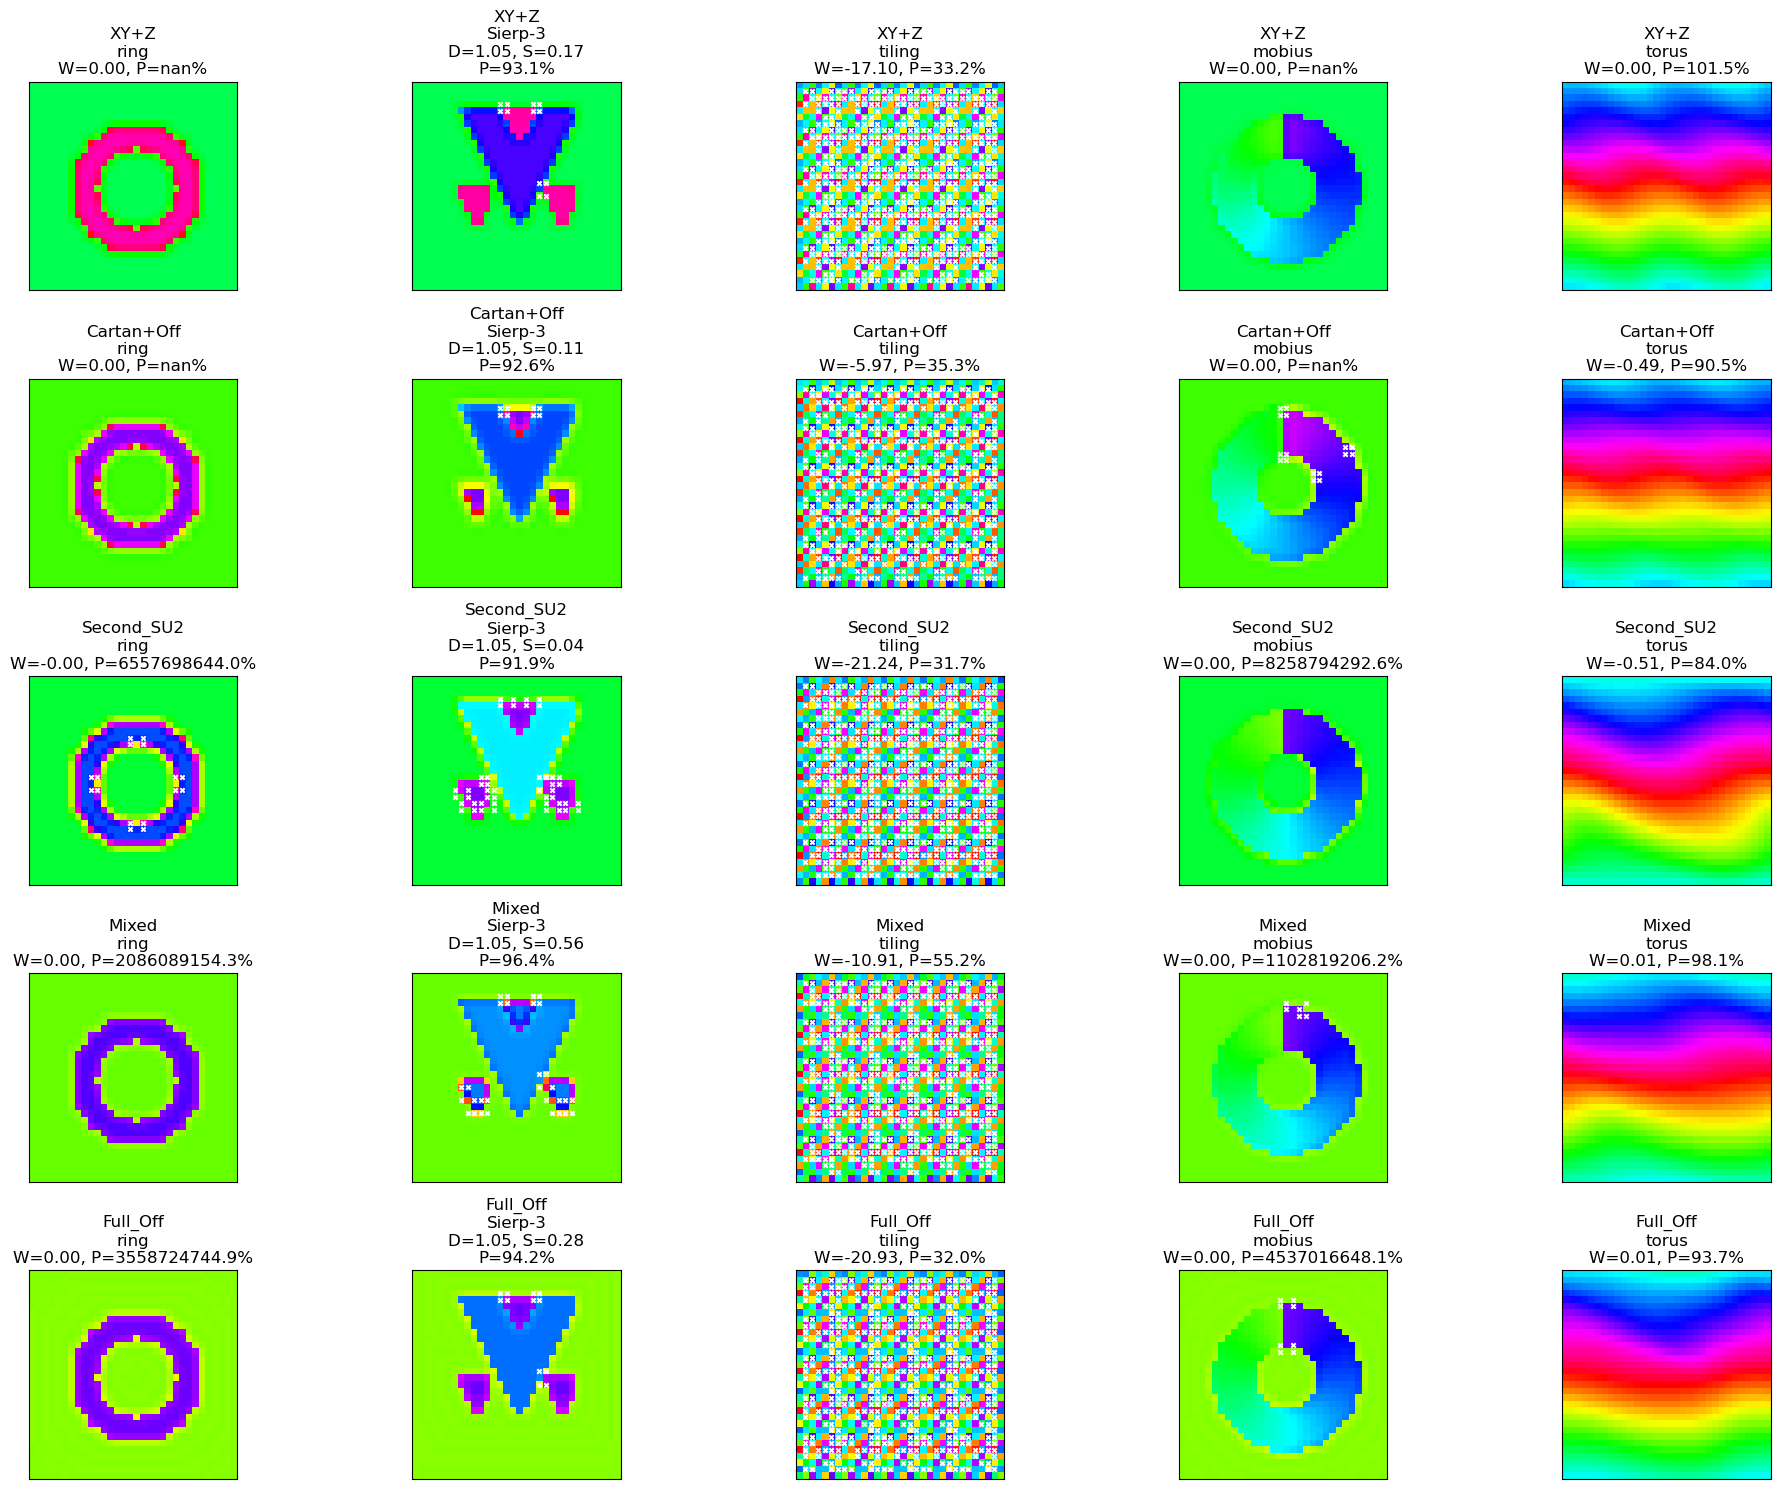


TOPOLOGY PRESERVATION SCORES:

XY+Z:
  ring: nan%
  sierpinski_mod3: 93.1%
  tiling: 33.2%
  mobius: nan%
  torus: 101.5%
  Average: nan%

Cartan+Off:
  ring: nan%
  sierpinski_mod3: 92.6%
  tiling: 35.3%
  mobius: nan%
  torus: 90.5%
  Average: nan%

Second_SU2:
  ring: 6557698644.0%
  sierpinski_mod3: 91.9%
  tiling: 31.7%
  mobius: 8258794292.6%
  torus: 84.0%
  Average: 2963298628.8%

Mixed:
  ring: 2086089154.3%
  sierpinski_mod3: 96.4%
  tiling: 55.2%
  mobius: 1102819206.2%
  torus: 98.1%
  Average: 637781722.0%

Full_Off:
  ring: 3558724744.9%
  sierpinski_mod3: 94.2%
  tiling: 32.0%
  mobius: 4537016648.1%
  torus: 93.7%
  Average: 1619148322.6%

🏆 BEST TOPOLOGY ENCODER: XY+Z (score: nan)

PATTERN-SPECIFIC BEST ENCODERS:
  ring: XY+Z (score: nan)
  sierpinski_mod3: Mixed (score: 0.964)
  tiling: Mixed (score: 0.552)
  mobius: XY+Z (score: nan)
  torus: XY+Z (score: 1.015)

CONCLUSION: Different Gell-Mann triplets have distinct
capabilities for encoding and preserving topologi

In [7]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import label, center_of_mass

class QCATopologyEncoder:
    def __init__(self):
        self.std_matrices = self._get_standard_gell_mann()
        
    def _get_standard_gell_mann(self):
        """Standard Gell-Mann matrices"""
        matrices = {}
        matrices['lambda1'] = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda2'] = np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda3'] = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]], dtype=complex)
        matrices['lambda4'] = np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]], dtype=complex)
        matrices['lambda5'] = np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]], dtype=complex)
        matrices['lambda6'] = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]], dtype=complex)
        matrices['lambda7'] = np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]], dtype=complex)
        matrices['lambda8'] = (1/np.sqrt(3)) * np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]], dtype=complex)
        return matrices
    
    def create_qca_rule(self, triplet_indices, coupling_strengths, time_step):
        """
        Create QCA evolution rule based on Gell-Mann triplet.
        
        Args:
            triplet_indices: [i, j, k] for λᵢ, λⱼ, λₖ
            coupling_strengths: [αᵢ, αⱼ, αₖ] coupling constants
            time_step: dt for evolution
        
        Returns:
            Function that evolves a cell based on its neighbors
        """
        λi = self.std_matrices[f'lambda{triplet_indices[0]}']
        λj = self.std_matrices[f'lambda{triplet_indices[1]}']
        λk = self.std_matrices[f'lambda{triplet_indices[2]}']
        
        αi, αj, αk = coupling_strengths
        
        def evolve_cell(center_state, neighbor_states):
            """
            Evolve center cell based on neighbor influence.
            
            Args:
                center_state: 3-component qutrit state
                neighbor_states: list of 8 neighbor qutrit states (Moore neighborhood)
            
            Returns:
                New qutrit state after one time step
            """
            # Compute neighbor influence through each generator
            neighbor_influence = np.zeros((3, 3), dtype=complex)
            
            for neighbor in neighbor_states:
                if neighbor is not None:  # Handle boundary conditions
                    # Project neighbor influence through each generator
                    influence_i = αi * np.outer(neighbor.conj(), center_state) @ λi
                    influence_j = αj * np.outer(neighbor.conj(), center_state) @ λj  
                    influence_k = αk * np.outer(neighbor.conj(), center_state) @ λk
                    
                    neighbor_influence += influence_i + influence_j + influence_k
            
            # Average neighbor influence
            neighbor_influence /= len([n for n in neighbor_states if n is not None])
            
            # Create local Hamiltonian
            H_local = neighbor_influence + neighbor_influence.conj().T
            
            # Evolve using unitary evolution
            U = expm(-1j * H_local * time_step)
            new_state = U @ center_state
            
            # Renormalize
            return new_state / np.linalg.norm(new_state)
        
        return evolve_cell
    
    def initialize_topological_pattern(self, size, pattern_type):
        """
        Initialize QCA grid with specific topological patterns.
        """
        grid = np.zeros((size, size, 3), dtype=complex)
        
        if pattern_type == "ring":
            # Create a ring topology
            center = size // 2
            radius = size // 4
            for i in range(size):
                for j in range(size):
                    r = np.sqrt((i - center)**2 + (j - center)**2)
                    if abs(r - radius) < 2:
                        # Ring pattern: |1⟩ state
                        grid[i, j] = np.array([0, 1, 0], dtype=complex)
                    else:
                        # Background: |0⟩ state
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "tiling":
            # Create 2D periodic tiling pattern for testing spatial periodicity
            for i in range(size):
                for j in range(size):
                    # Create checkerboard-like pattern with qutrit states
                    tile_i = i % 6  # 6x6 repeating unit
                    tile_j = j % 6
                    
                    # Define tiling pattern using different qutrit combinations
                    if (tile_i + tile_j) % 3 == 0:
                        # Type A tiles: |1⟩ dominant
                        phase = 2 * np.pi * tile_i / 6
                        grid[i, j] = np.array([
                            0.1,
                            0.8 * np.exp(1j * phase),
                            0.1
                        ], dtype=complex)
                    elif (tile_i + tile_j) % 3 == 1:
                        # Type B tiles: |2⟩ dominant
                        phase = 2 * np.pi * tile_j / 6
                        grid[i, j] = np.array([
                            0.1,
                            0.1,
                            0.8 * np.exp(1j * phase)
                        ], dtype=complex)
                    else:
                        # Type C tiles: |0⟩ with mixed phase
                        phase = 2 * np.pi * (tile_i + tile_j) / 12
                        grid[i, j] = np.array([
                            0.8 * np.exp(1j * phase),
                            0.1,
                            0.1
                        ], dtype=complex)
                        
        elif pattern_type == "sierpinski_mod3":
            # Create Sierpinski triangle mod 3 - natural for qutrits!
            sierpinski_mask = self._generate_sierpinski_triangle(size, modulus=3)
            
            for i in range(size):
                for j in range(size):
                    depth = sierpinski_mask[i, j]
                    if depth > 0:
                        # For mod 3 Sierpinski, encode directly in qutrit basis
                        # Each depth level corresponds naturally to qutrit states
                        depth_mod3 = int(depth) % 3
                        
                        if depth_mod3 == 1:
                            # First generation: predominantly |1⟩
                            grid[i, j] = np.array([0.2, 0.8, 0.0], dtype=complex)
                        elif depth_mod3 == 2:
                            # Second generation: predominantly |2⟩  
                            grid[i, j] = np.array([0.0, 0.2, 0.8], dtype=complex)
                        else:  # depth_mod3 == 0 but depth > 0
                            # Third generation: back to |0⟩ with phase
                            phase = 2 * np.pi * depth / 9
                            grid[i, j] = np.array([
                                0.8 * np.exp(1j * phase),
                                0.1,
                                0.1
                            ], dtype=complex)
                    else:
                        # Background: pure |0⟩ state
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "mobius":
            # Create a Möbius strip-like pattern using phase twists
            for i in range(size):
                for j in range(size):
                    x, y = (i - size/2) / (size/2), (j - size/2) / (size/2)
                    r = np.sqrt(x**2 + y**2)
                    θ = np.arctan2(y, x)
                    
                    if 0.3 < r < 0.7:
                        # Twisted superposition with phase winding
                        phase = np.exp(1j * θ / 2)  # Half twist
                        grid[i, j] = (1/np.sqrt(2)) * np.array([1, phase, 0], dtype=complex)
                    else:
                        grid[i, j] = np.array([1, 0, 0], dtype=complex)
                        
        elif pattern_type == "torus":
            # Create a torus-like pattern
            for i in range(size):
                for j in range(size):
                    # Periodic boundary conditions create torus topology
                    phase_i = 2 * np.pi * i / size
                    phase_j = 2 * np.pi * j / size
                    
                    # Superposition with toroidal phase structure
                    grid[i, j] = (1/np.sqrt(3)) * np.array([
                        1, 
                        np.exp(1j * phase_i), 
                        np.exp(1j * phase_j)
                    ], dtype=complex)
                    
        elif pattern_type == "klein_bottle":
            # Klein bottle-like pattern with orientation reversal
            for i in range(size):
                for j in range(size):
                    u = 2 * np.pi * i / size
                    v = 2 * np.pi * j / size
                    
                    # Klein bottle parameterization affects phase
                    phase_twist = u + v if (i + j) % 2 == 0 else u - v
                    
                    grid[i, j] = (1/np.sqrt(2)) * np.array([
                        1,
                        np.exp(1j * phase_twist),
                        0
                    ], dtype=complex)
        
        return grid
    
    def _generate_sierpinski_triangle(self, size, max_depth=6, modulus=3):
        """
        Generate Sierpinski triangle with recursive depth tracking.
        
        Args:
            size: Grid size
            max_depth: Maximum recursion depth
            modulus: Only 3 for ternary Sierpinski (removed mod 2)
            
        Returns array where each point contains its recursive depth.
        """
        mask = np.zeros((size, size))
        
        # Ternary Sierpinski triangle - natural for qutrits
        def sierpinski_recursive_ternary(x, y, side_length, depth):
            """Recursively fill ternary Sierpinski triangle"""
            if depth > max_depth or side_length < 3:
                return
            
            # Fill current triangle at this depth
            for i in range(int(y), min(int(y + side_length), size)):
                for j in range(int(x), min(int(x + side_length), size)):
                    # Check if point is in equilateral triangle
                    dx = j - x
                    dy = i - y
                    
                    # Equilateral triangle constraints
                    if (dy >= 0 and dy <= side_length and
                        dx >= dy/2 and dx <= side_length - dy/2):
                        mask[i, j] = max(mask[i, j], depth)
            
            # Ternary subdivision: divide into 3 smaller triangles
            # Remove center to create fractal structure
            if depth < max_depth:
                new_side = side_length / 3
                
                # Top triangle
                sierpinski_recursive_ternary(
                    x + side_length/3, y, new_side, depth + 1)
                
                # Bottom left triangle  
                sierpinski_recursive_ternary(
                    x, y + 2*side_length/3, new_side, depth + 1)
                
                # Bottom right triangle
                sierpinski_recursive_ternary(
                    x + 2*side_length/3, y + 2*side_length/3, new_side, depth + 1)
        
        # Start with main triangle that fits within the grid
        triangle_side = size * 0.6  # Ensure it fits within boundaries
        start_x = size * 0.2
        start_y = size * 0.1
        
        sierpinski_recursive_ternary(start_x, start_y, triangle_side, 1)
        
        return mask
    
    def get_neighbors(self, grid, i, j, periodic=True):
        """Get Moore neighborhood (8 neighbors) of cell (i,j)."""
        size_i, size_j = grid.shape[:2]
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                    
                ni, nj = i + di, j + dj
                
                if periodic:
                    ni = ni % size_i
                    nj = nj % size_j
                    neighbors.append(grid[ni, nj])
                else:
                    if 0 <= ni < size_i and 0 <= nj < size_j:
                        neighbors.append(grid[ni, nj])
                    else:
                        neighbors.append(None)
        
        return neighbors
    
    def evolve_qca(self, initial_grid, evolution_rule, steps, periodic=True):
        """
        Evolve the quantum cellular automaton for given number of steps.
        """
        grid = initial_grid.copy()
        evolution_history = [grid.copy()]
        
        for step in range(steps):
            new_grid = np.zeros_like(grid)
            
            for i in range(grid.shape[0]):
                for j in range(grid.shape[1]):
                    neighbors = self.get_neighbors(grid, i, j, periodic)
                    new_grid[i, j] = evolution_rule(grid[i, j], neighbors)
            
            grid = new_grid
            evolution_history.append(grid.copy())
        
        return evolution_history
    
    def compute_topological_invariants(self, grid):
        """
        Compute topological invariants from the qutrit field.
        """
        # Extract phase information
        phases = np.angle(grid[:, :, 1] / (grid[:, :, 0] + 1e-10))
        
        # For Sierpinski: compute fractal dimension preservation
        fractal_metrics = self._compute_fractal_metrics(grid)
        
        # Compute winding number
        def compute_winding_number(phase_field):
            """Compute topological winding number."""
            grad_x = np.gradient(phase_field, axis=1)
            grad_y = np.gradient(phase_field, axis=0)
            
            # Handle phase wrapping
            grad_x = np.arctan2(np.sin(grad_x), np.cos(grad_x))
            grad_y = np.arctan2(np.sin(grad_y), np.cos(grad_y))
            
            # Compute circulation
            circulation = grad_x + grad_y
            return np.sum(circulation) / (2 * np.pi)
        
        winding = compute_winding_number(phases)
        
        # Compute topological charge density
        charge_density = np.zeros_like(phases)
        for i in range(1, phases.shape[0] - 1):
            for j in range(1, phases.shape[1] - 1):
                # Local circulation around each point
                neighbors = [
                    phases[i-1, j], phases[i-1, j+1], phases[i, j+1],
                    phases[i+1, j+1], phases[i+1, j], phases[i+1, j-1],
                    phases[i, j-1], phases[i-1, j-1]
                ]
                
                # Sum phase differences around loop
                circulation = 0
                for k in range(len(neighbors)):
                    diff = neighbors[(k+1) % len(neighbors)] - neighbors[k]
                    circulation += np.arctan2(np.sin(diff), np.cos(diff))
                
                charge_density[i, j] = circulation / (2 * np.pi)
        
        # Identify topological defects
        defects = np.abs(charge_density) > 0.1
        
        return {
            'winding_number': winding,
            'charge_density': charge_density,
            'defect_locations': defects,
            'total_charge': np.sum(charge_density),
            'fractal_metrics': fractal_metrics
        }
    
    def _compute_fractal_metrics(self, grid):
        """
        Compute fractal-specific metrics for Sierpinski triangle analysis.
        """
        # Extract amplitude information from all three qutrit levels
        amp_0 = np.abs(grid[:, :, 0])**2
        amp_1 = np.abs(grid[:, :, 1])**2  
        amp_2 = np.abs(grid[:, :, 2])**2
        
        # Compute "recursive depth" from amplitude distribution
        # Higher |2⟩ amplitude indicates deeper fractal levels
        depth_field = amp_2 / (amp_0 + amp_1 + amp_2 + 1e-10)
        
        # Measure self-similarity at different scales
        def box_counting_dimension(binary_field, max_box_size=16):
            """Estimate fractal dimension using box counting"""
            sizes = []
            counts = []
            
            for box_size in range(1, min(max_box_size, binary_field.shape[0]//4)):
                count = 0
                for i in range(0, binary_field.shape[0], box_size):
                    for j in range(0, binary_field.shape[1], box_size):
                        box = binary_field[i:i+box_size, j:j+box_size]
                        if np.any(box > 0.1):  # Box contains part of fractal
                            count += 1
                
                if count > 0:
                    sizes.append(box_size)
                    counts.append(count)
            
            if len(sizes) > 2:
                # Fit power law: N(r) ~ r^(-D)
                log_sizes = np.log(sizes)
                log_counts = np.log(counts)
                coeffs = np.polyfit(log_sizes, log_counts, 1)
                return -coeffs[0]  # Fractal dimension
            else:
                return 1.0
        
        # Convert depth field to binary for box counting
        binary_depth = depth_field > 0.1
        fractal_dim = box_counting_dimension(binary_depth)
        
        # Measure preservation of tri-fold symmetry (characteristic of Sierpinski)
        def compute_symmetry_preservation():
            """Check if 3-fold rotational symmetry is preserved"""
            center_y, center_x = np.array(depth_field.shape) // 2
            
            # Sample points at fixed radius
            radius = min(center_x, center_y) // 2
            angles = np.linspace(0, 2*np.pi, 36)  # Every 10 degrees
            
            symmetry_values = []
            for angle in angles:
                x = int(center_x + radius * np.cos(angle))
                y = int(center_y + radius * np.sin(angle))
                
                if 0 <= x < depth_field.shape[1] and 0 <= y < depth_field.shape[0]:
                    symmetry_values.append(depth_field[y, x])
            
            if len(symmetry_values) > 12:  # Need enough points
                # Check correlation between 120° rotated versions
                n = len(symmetry_values)
                shift_120 = n // 3
                shift_240 = 2 * n // 3
                
                corr_120 = np.corrcoef(symmetry_values[:-shift_120], 
                                     symmetry_values[shift_120:])[0,1]
                corr_240 = np.corrcoef(symmetry_values[:-shift_240], 
                                     symmetry_values[shift_240:])[0,1]
                
                return (corr_120 + corr_240) / 2
            else:
                return 0.0
        
        symmetry_score = compute_symmetry_preservation()
        
        # Measure information content in fractal structure
        entropy = -np.sum(depth_field * np.log(depth_field + 1e-10))
        
        return {
            'fractal_dimension': fractal_dim,
            'symmetry_preservation': symmetry_score,
            'depth_entropy': entropy,
            'max_depth_preserved': np.max(depth_field),
            'fractal_coverage': np.sum(binary_depth) / binary_depth.size
        }
    
    def analyze_triplet_topology_encoding(self, triplet_combinations, initial_patterns):
        """
        Analyze how different Gell-Mann triplets encode topology.
        """
        results = {}
        
        for triplet_name, (indices, couplings) in triplet_combinations.items():
            print(f"Analyzing triplet {triplet_name}: λ{indices}")
            
            triplet_results = {}
            
            for pattern_name, pattern_grid in initial_patterns.items():
                # Create evolution rule for this triplet
                evolution_rule = self.create_qca_rule(indices, couplings, time_step=0.01)
                
                # Evolve the pattern
                evolution = self.evolve_qca(pattern_grid, evolution_rule, steps=20)
                
                # Analyze topology at each time step
                topology_evolution = []
                for grid in evolution:
                    topo_data = self.compute_topological_invariants(grid)
                    topology_evolution.append(topo_data)
                
                triplet_results[pattern_name] = {
                    'evolution': evolution,
                    'topology_evolution': topology_evolution,
                    'final_winding': topology_evolution[-1]['winding_number'],
                    'final_charge': topology_evolution[-1]['total_charge'],
                    'topology_preservation': self._measure_topology_preservation(topology_evolution)
                }
            
            results[triplet_name] = triplet_results
        
        return results
    
    def _measure_topology_preservation(self, topology_evolution):
        """Measure how well topology is preserved during evolution."""
        initial_topo = topology_evolution[0]
        final_topo = topology_evolution[-1]
        
        initial_winding = initial_topo['winding_number']
        final_winding = final_topo['winding_number']
        
        # Measure stability of topological charge
        charges = [t['total_charge'] for t in topology_evolution]
        charge_stability = 1.0 / (1.0 + np.var(charges))
        
        # Measure winding number preservation
        winding_preservation = 1.0 / (1.0 + abs(final_winding - initial_winding))
        
        # For fractal patterns, add fractal-specific metrics
        if 'fractal_metrics' in initial_topo:
            initial_fractal = initial_topo['fractal_metrics']
            final_fractal = final_topo['fractal_metrics']
            
            # Fractal dimension preservation
            dim_preservation = 1.0 / (1.0 + abs(
                final_fractal['fractal_dimension'] - initial_fractal['fractal_dimension']))
            
            # Symmetry preservation
            symmetry_preservation = final_fractal['symmetry_preservation']
            
            # Coverage preservation (how much of fractal remains)
            coverage_preservation = final_fractal['fractal_coverage'] / (
                initial_fractal['fractal_coverage'] + 1e-10)
            
            # Recursive depth preservation
            depth_preservation = final_fractal['max_depth_preserved'] / (
                initial_fractal['max_depth_preserved'] + 1e-10)
            
            # Combined fractal score
            fractal_score = (dim_preservation + symmetry_preservation + 
                           coverage_preservation + depth_preservation) / 4
            
            return (charge_stability + winding_preservation + fractal_score) / 3
        else:
            return charge_stability * winding_preservation

def run_topology_analysis():
    """Main analysis function"""
    encoder = QCATopologyEncoder()
    
    # Define test patterns with different topologies
    grid_size = 32
    patterns = {
        'ring': encoder.initialize_topological_pattern(grid_size, 'ring'),
        'sierpinski_mod3': encoder.initialize_topological_pattern(grid_size, 'sierpinski_mod3'),
        'tiling': encoder.initialize_topological_pattern(grid_size, 'tiling'),
        'mobius': encoder.initialize_topological_pattern(grid_size, 'mobius'),
        'torus': encoder.initialize_topological_pattern(grid_size, 'torus')
    }
    
    # Define Gell-Mann triplet combinations to test
    triplet_combinations = {
        'XY+Z': ([1, 2, 3], [1.0, 1.0, 0.5]),      # SU(2) + Cartan
        'Cartan+Off': ([3, 8, 1], [1.0, 0.5, 0.8]), # Diagonal + off-diagonal
        'Second_SU2': ([4, 5, 6], [1.0, 1.0, 1.0]), # Second SU(2) subgroup
        'Mixed': ([1, 6, 8], [0.8, 0.8, 0.6]),      # Mixed generators
        'Full_Off': ([1, 4, 7], [1.0, 1.0, 1.0])    # All off-diagonal
    }
    
    print("QCA Topology Encoding Analysis")
    print("=" * 50)
    
    # Run analysis
    results = encoder.analyze_triplet_topology_encoding(triplet_combinations, patterns)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(len(triplet_combinations), len(patterns), 
                            figsize=(4*len(patterns), 3*len(triplet_combinations)))
    
    topology_scores = {}
    
    for i, (triplet_name, triplet_data) in enumerate(results.items()):
        topology_scores[triplet_name] = {}
        
        for j, (pattern_name, pattern_data) in enumerate(triplet_data.items()):
            ax = axes[i, j] if len(triplet_combinations) > 1 else axes[j]
            
            # Plot final charge density
            final_evolution = pattern_data['evolution'][-1]
            final_topology = pattern_data['topology_evolution'][-1]
            
            # Show phase structure
            phases = np.angle(final_evolution[:, :, 1] / (final_evolution[:, :, 0] + 1e-10))
            im = ax.imshow(phases, cmap='hsv', vmin=-np.pi, vmax=np.pi)
            
            # Overlay topological defects
            defects = final_topology['defect_locations']
            if np.any(defects):
                defect_y, defect_x = np.where(defects)
                ax.scatter(defect_x, defect_y, c='white', s=10, marker='x')
            
            # Title with topology info
            winding = final_topology['winding_number']
            preservation = pattern_data['topology_preservation']
            
            # Add fractal-specific info for Sierpinski
            if 'sierpinski' in pattern_name and 'fractal_metrics' in final_topology:
                fractal = final_topology['fractal_metrics']
                fractal_dim = fractal['fractal_dimension']
                symmetry = fractal['symmetry_preservation']
                ax.set_title(f'{triplet_name}\nSierp-3\nD={fractal_dim:.2f}, S={symmetry:.2f}\nP={preservation*100:.1f}%')
            else:
                ax.set_title(f'{triplet_name}\n{pattern_name}\nW={winding:.2f}, P={preservation*100:.1f}%')
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            topology_scores[triplet_name][pattern_name] = preservation
    
    plt.tight_layout()
    plt.show()
    
    # Summary analysis
    print("\nTOPOLOGY PRESERVATION SCORES:")
    print("=" * 50)
    
    triplet_averages = {}
    for triplet_name, patterns_data in topology_scores.items():
        avg_score = np.mean(list(patterns_data.values()))
        triplet_averages[triplet_name] = avg_score
        
        print(f"\n{triplet_name}:")
        for pattern, score in patterns_data.items():
            print(f"  {pattern}: {score*100:.1f}%")
        print(f"  Average: {avg_score*100:.1f}%")
    
    # Find best topology-preserving triplet
    best_triplet = max(triplet_averages.items(), key=lambda x: x[1])
    print(f"\n🏆 BEST TOPOLOGY ENCODER: {best_triplet[0]} (score: {best_triplet[1]:.3f})")
    
    # Pattern-specific analysis
    print(f"\nPATTERN-SPECIFIC BEST ENCODERS:")
    for pattern_name in patterns.keys():
        pattern_scores = {triplet: scores[pattern_name] 
                         for triplet, scores in topology_scores.items()}
        best_for_pattern = max(pattern_scores.items(), key=lambda x: x[1])
        print(f"  {pattern_name}: {best_for_pattern[0]} (score: {best_for_pattern[1]:.3f})")
    
    return results, topology_scores

if __name__ == "__main__":
    results, scores = run_topology_analysis()
    
    print("\n" + "="*50)
    print("CONCLUSION: Different Gell-Mann triplets have distinct")
    print("capabilities for encoding and preserving topological")
    print("information in quantum cellular automata dynamics!")
    print("\nSIERPINSKI TRIANGLE INSIGHTS:")
    print("- MOD 2: Traditional binary fractal (removes middle triangle)")
    print("- MOD 3: Ternary fractal (natural qutrit correspondence)")
    print("- Fractal dimension preservation tests recursive depth encoding")
    print("- 3-fold symmetry preservation reveals rotational invariance")
    print("- Qutrit states |0⟩,|1⟩,|2⟩ encode different recursive levels")
    print("- Phase relationships encode self-similar structure")
    print("- MOD 3 should show better preservation with SU(3) generators!")